In [104]:
from FusekiCommunicator import FusekiCommunicatior
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict
from pydantic import BaseModel
from rdflib import Graph, URIRef, Literal, BNode

class ResponseHead(BaseModel):
    vars: list[str]

class ResponseResults(BaseModel):
    bindings: list[Dict[str, Any]]

class SearchResponse(BaseModel):
    head: ResponseHead
    results: ResponseResults
    
from starlette.responses import RedirectResponse
from starlette.status import (
    HTTP_303_SEE_OTHER,
    HTTP_400_BAD_REQUEST,
    HTTP_500_INTERNAL_SERVER_ERROR,
)
from fastapi import APIRouter, HTTPException
from loguru import logger

import datetime

In [105]:
triple_type = {
    'uri': URIRef,
    'literal': Literal,
    'bnode': BNode
}

In [30]:
fuseki_jena_url = "192.168.4.26"
fuseki_jena_port = "30731"
fuseki_jena_dataset_name = "slice"
fuseki = FusekiCommunicatior(
    fuseki_jena_url, fuseki_jena_port, fuseki_jena_dataset_name
)

http://192.168.4.26:30731/slice


In [4]:
def read_file(fname):
    with open(fname, "r") as f:
        return f.read()

def perform_query(query):
    valid, msg = fuseki.validate_sparql(query, "query")
    if valid:
        result = fuseki.read_query(query)
        bindings = []
        for item in result.bindings:
            new_item: Dict[str, Any] = {}
            for key in item:
                new_item[key] = {}
                for property in item[key].__dict__:
                    if (
                        property != "variable"
                        and item[key].__dict__[property] is not None
                    ):
                        new_item[key][property] = item[key].__dict__[property]
                        if property == "lang":
                            new_item[key]["xml:lang"] = new_item[key].pop("lang")
            bindings.append(new_item)
        return SearchResponse(
                head=ResponseHead(vars=result.head["vars"]),
                results=ResponseResults(bindings=bindings),
            )
    print(msg)
    return None

In [5]:
fuseki_jena_url_integration = "jena-fuseki.integration"
fuseki_jena_port_integration = None
fuseki_jena_dataset_name_integration = "slice"
fuseki_integration = FusekiCommunicatior(
    fuseki_jena_url_integration, fuseki_jena_port_integration, fuseki_jena_dataset_name_integration
)

http://jena-fuseki.integration/slice


In [6]:
def read_file(fname):
    with open(fname, "r") as f:
        return f.read()

def perform_query(query, fuseki):
    valid, msg = fuseki.validate_sparql(query, "query")
    if valid:
        result = fuseki.read_query(query)
        bindings = []
        for item in result.bindings:
            new_item: Dict[str, Any] = {}
            for key in item:
                new_item[key] = {}
                for property in item[key].__dict__:
                    if (
                        property != "variable"
                        and item[key].__dict__[property] is not None
                    ):
                        new_item[key][property] = item[key].__dict__[property]
                        if property == "lang":
                            new_item[key]["xml:lang"] = new_item[key].pop("lang")
            bindings.append(new_item)
        return SearchResponse(
                head=ResponseHead(vars=result.head["vars"]),
                results=ResponseResults(bindings=bindings),
            )
    print(msg)
    return None

In [120]:
timestamps = np.array(
    [
        timestamp["graphURI"]["value"]
        for timestamp in perform_query(
            read_file("query_timestamps.txt"), fuseki_integration
        ).results.bindings
    ]
)
print(f"{timestamps.size} timestamps retreived.")

print("Getting the size of the named graphs.")
graph_sizes = []
for i in range(timestamps.size):
    print(f"{i/(timestamps.size-1)*100:.2f}%", end="\r")
    # graph_sizes.append(number_of_triples(timestamps[i]))
graph_sizes = np.array(graph_sizes)

2319 timestamps retreived.
Getting the size of the named graphs.


In [89]:
milisec_in_24h = 24*60*60*1000

In [90]:
1730975406137-milisec_in_24h

1730889006137

In [97]:
unix_timestamp=int(timestamps[-1].split(':')[-1])/1000
dt_object = datetime.datetime.fromtimestamp(unix_timestamp)
formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S')
print("Formatted time:", formatted_time)


Formatted time: 2024-11-07 11:30:06


In [111]:
print(dt_object)

2024-11-07 11:30:06.137000


In [94]:
unix_timestamp

1730975406137

In [93]:
unix_timestamp

1730975406137

In [87]:
timestamps[-1]

np.str_('timestamp:1730975406137')

In [9]:
len(timestamps)

1419

In [10]:
((int(timestamps[-1].split(':')[-1])-int(timestamps[0].split(':')[-1]))/1000)/60

8950.04515

In [11]:
def tti(timestamp):
    return int(timestamp.split(':')[-1])

In [12]:
diffs = np.zeros(len(timestamps)-1)
for i in range(1,len(timestamps)):
    diffs[i-1] = (tti(timestamps[i])-tti(timestamps[i-1]))/(600*1000)

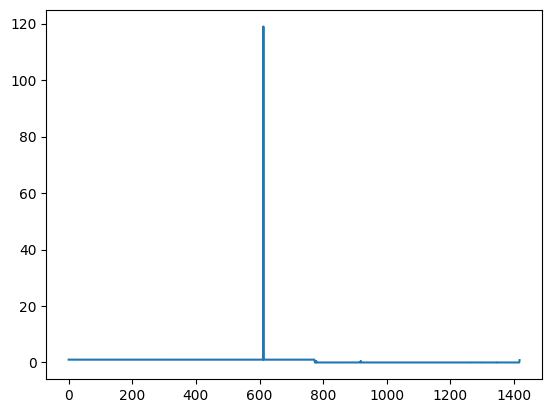

In [13]:
plt.plot(diffs)

In [14]:
120*10/60

20.0

In [15]:
def get_graph_from_bindings(bindings):
    g = Graph()

    for binding in bindings: #response.results.bindings:
        g.add((triple_type[binding['s']['type']](binding['s']['value']), triple_type[binding['p']['type']](binding['p']['value']), triple_type[binding['o']['type']](binding['o']['value'])))
    
    return g

In [16]:
fname = "simple_query.txt"

query = read_file(fname).replace("graph1", timestamps[0]) #.replace("graph2", timestamps[1])
response = perform_query(query, fuseki_integration)
g0 = get_graph_from_bindings(response.results.bindings)


In [45]:
g0

<Graph identifier=N16fc6af624ca486186e8398942dfebe1 (<class 'rdflib.graph.Graph'>)>

In [49]:
def read_graph_from_time_stamp(timestamp):
    fname = "simple_query.txt"

    query = read_file(fname).replace("graph1", timestamp)
    response = perform_query(query, fuseki_integration)
    g = get_graph_from_bindings(response.results.bindings)

    return g

In [54]:
def compose_insert_query_form_graph(g: Graph, graph_name: str) -> str:
    n_triples = 0
    query = "INSERT DATA {\n"
    query += "\tGRAPH <" + graph_name + "> {\n"  # "\tGRAPH <timestamp:%d> {\n" % ts
    for s, p, o in g.triples((None, None, None)):
        if hasattr(s, "n3") and hasattr(p, "n3") and hasattr(o, "n3"):
            query += f"\t\t{s.n3()} {p.n3()} {o.n3()} .\n"
            n_triples += 1
        else:
            raise HTTPException(
                HTTP_500_INTERNAL_SERVER_ERROR, "Error in parsing JSON-LD."
            )
    query += "\t}\n"
    query += "}"

    valid, msg = fuseki.validate_sparql(query, "update")
    
    # return query, valid, msg
    if n_triples == 0:
        logger.error("No triples could be extracted from Graph")
        raise HTTPException(
            HTTP_400_BAD_REQUEST, "No triples could be extracted from Graph."
        )
        
    elif valid:
        logger.debug(f"Return query with {n_triples} triple(s) and name {graph_name}.")
        return query        
    else:
        logger.error(msg)
        logger.debug(f"The query:\n{query}")
        raise HTTPException(HTTP_500_INTERNAL_SERVER_ERROR, msg)


In [37]:
n_triples = 0
query = "INSERT DATA {\n"
query += "\tGRAPH <"+timestamps[0] + "> {\n"  #"\tGRAPH <timestamp:%d> {\n" % ts
for s, p, o in g0.triples((None, None, None)):
    if hasattr(s, "n3") and hasattr(p, "n3") and hasattr(o, "n3"):
        query += f"\t\t{s.n3()} {p.n3()} {o.n3()} .\n"
        n_triples += 1
    else:
        raise HTTPException(
            HTTP_500_INTERNAL_SERVER_ERROR, "Error in parsing JSON-LD."
        )
query += "\t}\n"
query += "}"

valid, msg = fuseki.validate_sparql(query, "update")


In [55]:
def write_to_Jena_with_deltas(g: Graph, timestamp: str):
    
    added_data_graph  = g-g0
    removed_data_graph  = g0-g
    
    added_graph_label = timestamp+'/added'
    removed_graph_label = timestamp+'/removed'
    
    query_insert_added = compose_insert_query_form_graph(added_data_graph, added_graph_label)
    query_insert_removed = compose_insert_query_form_graph(removed_data_graph, removed_graph_label)
    fuseki.update_query(query_insert_added)
    fuseki.update_query(query_insert_removed)
    

In [98]:
100 % 50

0

In [121]:
for i in range(len(timestamps)):
    if i % 50 == 0:
        print(i, " of ", len(timestamps))
        g1=read_graph_from_time_stamp(timestamps[i])
        query = compose_insert_query_form_graph(g1, timestamps[i])
        fuseki.update_query(query)
    #write_to_Jena_with_deltas(g1, timestamps[i])
    

0  of  2319


2024-11-08 11:05:58.731 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8464 triple(s) and name timestamp:1730279403441.


50  of  2319


2024-11-08 11:06:18.053 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8437 triple(s) and name timestamp:1730309403375.


100  of  2319


2024-11-08 11:06:42.464 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8464 triple(s) and name timestamp:1730339403478.


150  of  2319


2024-11-08 11:07:08.005 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8466 triple(s) and name timestamp:1730369402920.


200  of  2319


2024-11-08 11:07:29.331 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8437 triple(s) and name timestamp:1730399402885.


250  of  2319


2024-11-08 11:07:54.164 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8466 triple(s) and name timestamp:1730429403089.


300  of  2319


2024-11-08 11:08:15.375 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8466 triple(s) and name timestamp:1730459403187.


350  of  2319


2024-11-08 11:08:37.070 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8435 triple(s) and name timestamp:1730489403171.


400  of  2319


2024-11-08 11:09:01.292 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8466 triple(s) and name timestamp:1730519403314.


450  of  2319


2024-11-08 11:09:30.955 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8464 triple(s) and name timestamp:1730549403406.


500  of  2319


2024-11-08 11:09:54.337 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8437 triple(s) and name timestamp:1730579403994.


550  of  2319


2024-11-08 11:10:11.554 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8464 triple(s) and name timestamp:1730609404171.


600  of  2319


2024-11-08 11:10:28.022 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8464 triple(s) and name timestamp:1730639403681.


650  of  2319


2024-11-08 11:10:45.467 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8732 triple(s) and name timestamp:1730740204747.


700  of  2319


2024-11-08 11:11:02.882 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8731 triple(s) and name timestamp:1730770205095.


750  of  2319


2024-11-08 11:11:20.735 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8525 triple(s) and name timestamp:1730800205044.


800  of  2319


2024-11-08 11:11:23.115 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 171 triple(s) and name timestamp:1730814646732.


850  of  2319


2024-11-08 11:11:23.657 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 147 triple(s) and name timestamp:1730814723146.


900  of  2319


2024-11-08 11:11:24.181 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 117 triple(s) and name timestamp:1730814824900.


950  of  2319


2024-11-08 11:11:24.808 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 171 triple(s) and name timestamp:1730815371657.


1000  of  2319


2024-11-08 11:11:25.393 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 147 triple(s) and name timestamp:1730815413175.


1050  of  2319


2024-11-08 11:11:26.026 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 117 triple(s) and name timestamp:1730815452946.


1100  of  2319


2024-11-08 11:11:26.576 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 117 triple(s) and name timestamp:1730815488869.


1150  of  2319


2024-11-08 11:11:27.245 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 171 triple(s) and name timestamp:1730815519746.


1200  of  2319


2024-11-08 11:11:27.859 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 147 triple(s) and name timestamp:1730815565704.


1250  of  2319


2024-11-08 11:11:28.619 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 219 triple(s) and name timestamp:1730815617889.


1300  of  2319


2024-11-08 11:11:29.322 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 195 triple(s) and name timestamp:1730815734878.


1350  of  2319


2024-11-08 11:11:46.464 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8664 triple(s) and name timestamp:1730815823788.


1400  of  2319


2024-11-08 11:11:48.953 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 147 triple(s) and name timestamp:1730815890989.


1450  of  2319


2024-11-08 11:12:18.512 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8671 triple(s) and name timestamp:1730836205329.


1500  of  2319


2024-11-08 11:12:46.095 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8645 triple(s) and name timestamp:1730866204796.


1550  of  2319


2024-11-08 11:13:07.053 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8645 triple(s) and name timestamp:1730895605342.


1600  of  2319


2024-11-08 11:13:29.805 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8708 triple(s) and name timestamp:1730925604861.


1650  of  2319


2024-11-08 11:13:48.452 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8708 triple(s) and name timestamp:1730956214894.


1700  of  2319


2024-11-08 11:13:50.895 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 184 triple(s) and name timestamp:1730973556596.


1750  of  2319


2024-11-08 11:13:51.626 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 184 triple(s) and name timestamp:1730973585322.


1800  of  2319


2024-11-08 11:13:52.157 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 113 triple(s) and name timestamp:1730973618548.


1850  of  2319


2024-11-08 11:13:52.660 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 113 triple(s) and name timestamp:1730973640635.


1900  of  2319


2024-11-08 11:13:53.292 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 152 triple(s) and name timestamp:1730973663234.


1950  of  2319


2024-11-08 11:13:53.921 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 152 triple(s) and name timestamp:1730973686000.


2000  of  2319


2024-11-08 11:13:54.738 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 216 triple(s) and name timestamp:1730973710020.


2050  of  2319


2024-11-08 11:13:55.524 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 216 triple(s) and name timestamp:1730973737221.


2100  of  2319


2024-11-08 11:13:56.040 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 113 triple(s) and name timestamp:1730973762607.


2150  of  2319


2024-11-08 11:13:56.630 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 152 triple(s) and name timestamp:1730973784344.


2200  of  2319


2024-11-08 11:14:11.887 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8894 triple(s) and name timestamp:1730989204949.


2250  of  2319


2024-11-08 11:14:28.533 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8878 triple(s) and name timestamp:1731019205919.


2300  of  2319


2024-11-08 11:14:52.202 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 8899 triple(s) and name timestamp:1731049205972.


In [108]:
len(timestamps)//50

43

In [109]:
timestamps[1000]

np.str_('timestamp:1730815413175')

In [122]:
def reconstruct_graph(timestamp):
    fname = "simple_query.txt"

    query_added = read_file(fname).replace("graph1", timestamp + '/added')
    response_added = perform_query(query_added, fuseki)
    g_added = get_graph_from_bindings(response_added.results.bindings)

    query_removed = read_file(fname).replace("graph1", timestamp + '/removed')
    response_removed = perform_query(query_removed, fuseki)
    g_removed = get_graph_from_bindings(response_removed.results.bindings)
    
    g=g0+g_added
    g=g-g_removed
    
    return g
    

In [74]:
%%time
for i in range(1,30):
    g_reconstructed = reconstruct_graph(timestamps[i])
    

CPU times: total: 7.38 s
Wall time: 21.3 s


In [75]:
%%time
for i in range(1,30):
    g_real=read_graph_from_time_stamp(timestamps[i])
    


CPU times: total: 10.9 s
Wall time: 57.7 s


In [79]:
fname = "super_simple_query.txt"

query = read_file(fname).replace("graph1", timestamps[29])

results=g_reconstructed.query(query)


In [84]:
for i, row in enumerate(results):
    if i<5:
        print(f"Subject: {row[0]}, Predicate: {row[1]}, Object: {row[2]}")

Subject: https://kubernetes.local/#argocd-dex-server, Predicate: glc:hasSubTask, Object: https://kubernetes.local/#argocd-dex-server-5c5c765c59
Subject: https://kubernetes.local/#uc2-workload-service-28838250, Predicate: glc:hasDescription, Object: Job
Subject: https://kubernetes.local/#glaciation-testm1w5-worker06withgpu.Network, Predicate: glc:hasID, Object: https://kubernetes.local/#glaciation-testm1w5-worker06withgpu.Network
Subject: glc:ResourceSpecification, Predicate: glc:makes, Object: https://kubernetes.local/#glaciation-testm1w5-worker01.RAM.Capacity.1730296798000
Subject: https://kubernetes.local/#gatekeeper-audit-5df6bc678b, Predicate: glc:hasConstraint, Object: https://kubernetes.local/#gatekeeper-audit-5df6bc678b.CPU.Allocated


In [82]:
row[0]

rdflib.term.URIRef('https://kubernetes.local/#longhorn-system.engine-image-ei-acb7590c-tjjgz.engine-image-ei-acb7590c')

In [85]:
# def create_daily_chunk()
g_daily_chunk = Graph()
sum_g_len = 0
for i in range(10):
    r_g = reconstruct_graph(timestamps[i])
    sum_g_len += len(r_g)
    g_daily_chunk += r_g
    
print(sum_g_len)
print(len(g_daily_chunk))

84719
13715


Do we need to store just all the triples generated during a day in a heap? Or we need that they still carry the time stamp.
If we need them to carry the timestamp then the deltas can still be used.

In [115]:
timestamps[101]

np.str_('timestamp:1730340003286')